In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import pickle

from B_data import *
from B_Plotting import Burgers_plot, loss_plot 

# Full PINN
from B_PINN1 import NN1
from B_PINN1_train import pinn1_train
#from B_PINN1_activation import P1
from B_PINN2_ind import NN2
from B_PINN2_train import pinn2_train

# Burgers GPT-PINN
from B_VGPT_activation import P
from B_VGPT1_PINN import GPT1
from B_VGPT1_train import gpt1_train
from B_VGPT2_PINN_ind import GPT2
from B_VGPT2_train import gpt2_train

torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [2]:
# Domain and Data
Xi, Xf         = -1.0, 1.5
Ti, Tf0         =  0.0, 0.1
Ti, Tf         =  0.0, 1.5
#Ti2, Tf2       =  1.0, 1.5
Nx_train0, Nt_train0 =  201, 101
Nx_test0,Nt_test0 = 1001, 2

Nx_train, Nt_train =  101,201
Nx_test, Nt_test = 101,201
IC_pts, IC_simple = 100, 100
BC_pts =  100
N_RH = IC_pts
dx = 0.001
dt = 0.0002

# Training Parameter Set
number_of_parameters = 3
nu1_training = np.linspace(0.5, 1, number_of_parameters)
nu2_training  = np.linspace(1.6, 2, number_of_parameters)

nu_training = []
for i in range(nu1_training.shape[0]):
    for j in range(nu2_training.shape[0]):
        nu_training.append([nu1_training[i],nu2_training[j]])
nu_training = np.array(nu_training)

In [3]:
lr_gpt1          = 0.001
lr_gpt2          = 0.0005
epochs_gpt1      = 5000
epochs_gpt2      = 2000
tol_gpt         = 5e-4

P1_list = np.ones(2, dtype=object)
P2_list = np.ones(2, dtype=object)

with open('IFNN_shock2_0516_cut.pkl', 'rb') as f:
    IFNN = pickle.load(f)
P1_list[0] = IFNN[0]
P2_list[0] = IFNN[1]
with open('IFNN_shock2_1020_cut.pkl', 'rb') as f:
    IFNN = pickle.load(f)
P1_list[1] = IFNN[0]
P2_list[1] = IFNN[1]

i=1
layers_gpt      = np.array([2, 2, 1])
c_initial  = torch.full((1,i+1), 1/(i+1))

[0.5 1.6] stopped at epoch: 0 | gpt_loss: 0.7669904828071594,rMAE: [0.2705613970756531], rRMSE:[0.24236509203910828], 0.036204125732183456, 0.03307834640145302, 0.03996872901916504, 3.1564952223561704e-05
[0.5 1.6] stopped at epoch: 2000 | gpt_loss: 0.02959355339407921,rMAE: 0.06307237595319748, rRMSE:0.06932524591684341, 0.0029319634195417166, 0.002446564845740795, 0.00013163035328034312, 8.796377369435504e-05
[0.5 1.6] stopped at epoch: 4000 | gpt_loss: 0.0012523506302386522,rMAE: 0.012033496052026749, rRMSE:0.03465980291366577, 0.0006298783118836582, 3.4157641493948177e-05, 1.0746443876996636e-06, 2.701494850043673e-05
[0.5 1.6] stopped at epoch: 5000 | gpt_loss: 0.001129457727074623,rMAE: 0.009723261930048466, rRMSE:0.03438521549105644, 0.0005961224669590592, 1.025081019179197e-05, 1.442869859147322e-07, 4.293843448976986e-05
layer1:tensor([[ 0.9093,  0.0591],
        [-0.0372,  1.0432]], device='cuda:0') and tensor([0.0591, 0.0804], device='cuda:0') and layer3:tensor([[0.9943, 0.0

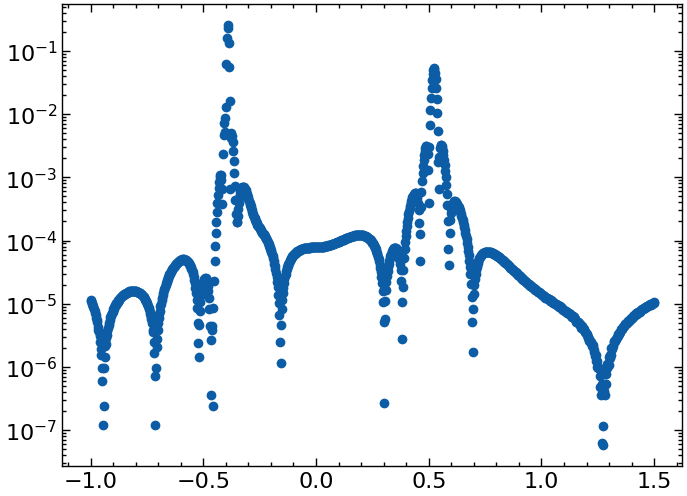

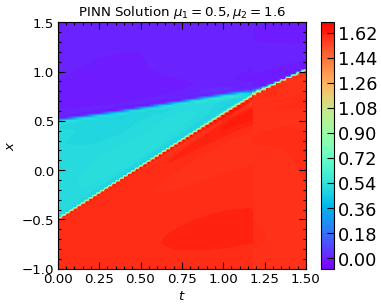

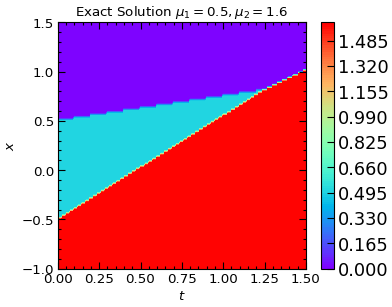

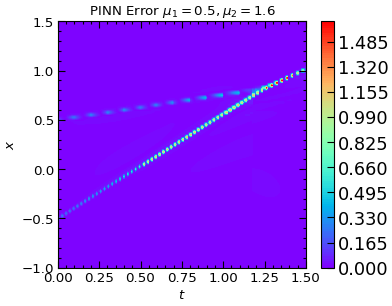

TGPT-PINN at mu_1=0.5,mu_2=1.6 with the rMAE = 0.013606352731585503 and rRMSE = 0.05693432316184044


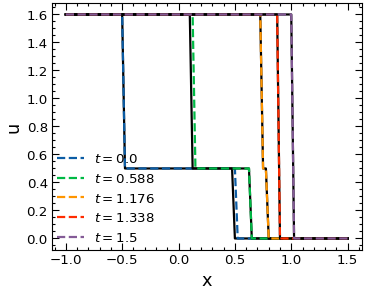

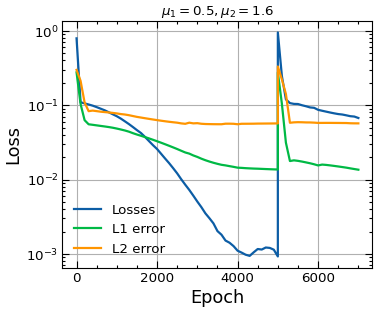

[0.5 1.8] stopped at epoch: 0 | gpt_loss: 0.2790542542934418,rMAE: [0.1747230738401413], rRMSE:[0.18971607089042664], 0.02828909084200859, 0.025044551119208336, 4.029145372896892e-07, 3.1564952223561704e-05
[0.5 1.8] stopped at epoch: 2000 | gpt_loss: 0.12514615058898926,rMAE: 0.10822554677724838, rRMSE:0.11837420612573624, 0.010923421941697598, 0.011230980046093464, 0.00016151541785802692, 2.977717485919129e-05
[0.5 1.8] stopped at epoch: 4000 | gpt_loss: 0.001236691023223102,rMAE: 0.01445862464606762, rRMSE:0.03638467565178871, 0.0006875033141113818, 5.429858356365003e-05, 6.200419875312946e-07, 1.5438689215940826e-10
[0.5 1.8] stopped at epoch: 5000 | gpt_loss: 0.0011646192288026214,rMAE: 0.013402299024164677, rRMSE:0.03411981835961342, 0.0006709524895995855, 4.8190362576860934e-05, 1.1761578662117245e-06, 1.515319952849481e-10
layer1:tensor([[ 0.7896,  0.0128],
        [-0.1643,  1.0453]], device='cuda:0') and tensor([0.1227, 0.1339], device='cuda:0') and layer3:tensor([[ 1.3268, -

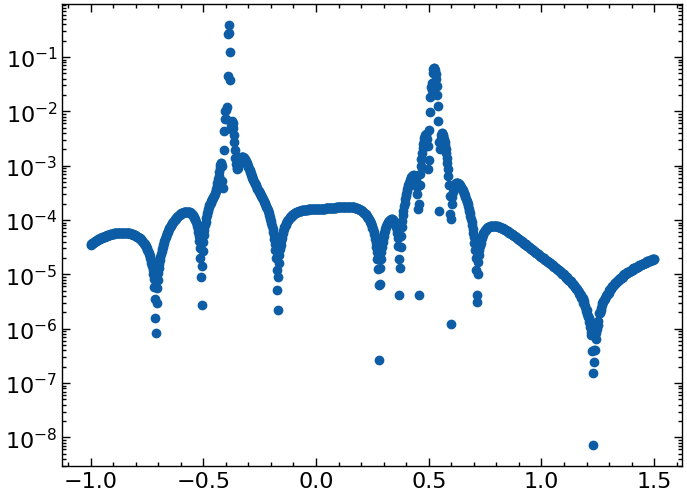

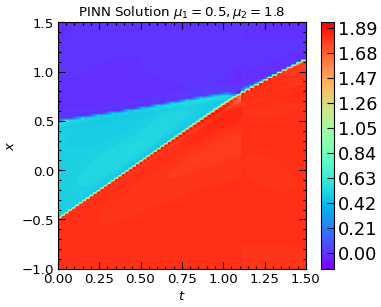

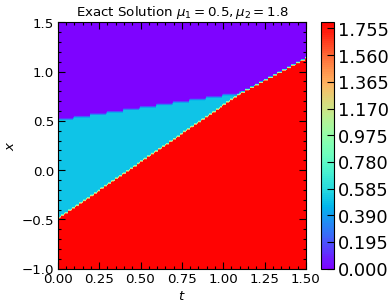

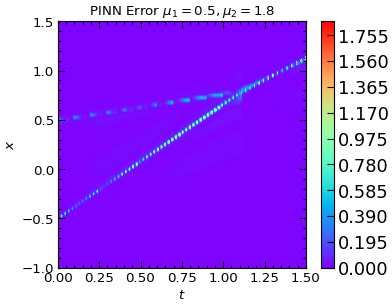

TGPT-PINN at mu_1=0.5,mu_2=1.8 with the rMAE = 0.008736960589885712 and rRMSE = 0.040028348565101624


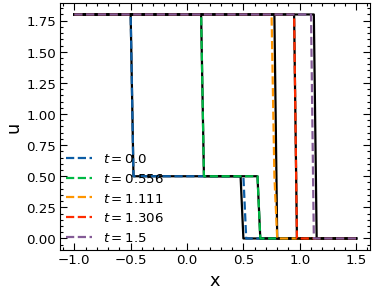

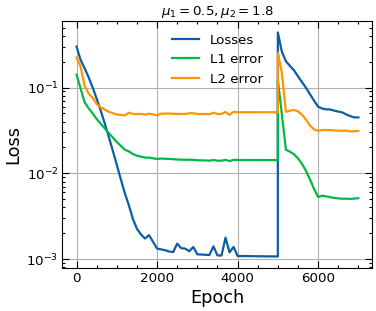

[0.5 2. ] stopped at epoch: 0 | gpt_loss: 0.7690012454986572,rMAE: [0.23141217231750488], rRMSE:[0.19821885228157043], 0.0382574088871479, 0.03301075100898743, 0.04003206640481949, 3.1564952223561704e-05
[0.5 2. ] stopped at epoch: 2000 | gpt_loss: 0.19925060868263245,rMAE: 0.12705585360527039, rRMSE:0.13183018565177917, 0.017504369840025902, 0.017858782783150673, 0.00027782347751781344, 3.801890125032514e-05
[0.5 2. ] stopped at epoch: 4000 | gpt_loss: 0.19878338277339935,rMAE: 0.1250297874212265, rRMSE:0.12991514801979065, 0.0170898474752903, 0.017843319103121758, 0.00027246211539022624, 5.357310510589741e-05
[0.5 2. ] stopped at epoch: 5000 | gpt_loss: 0.19866643846035004,rMAE: 0.1250215768814087, rRMSE:0.12978143990039825, 0.01703806407749653, 0.017838681116700172, 0.00027280295034870505, 5.135316678206436e-05
layer1:tensor([[ 1.1906,  0.8223],
        [-0.1210,  2.3416]], device='cuda:0') and tensor([0.4675, 0.2902], device='cuda:0') and layer3:tensor([[0.7778, 0.3677]], device='c

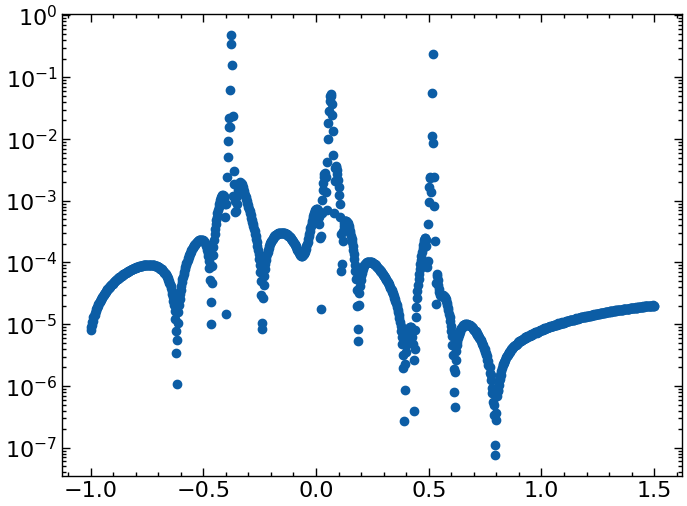

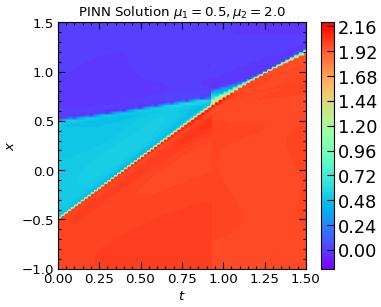

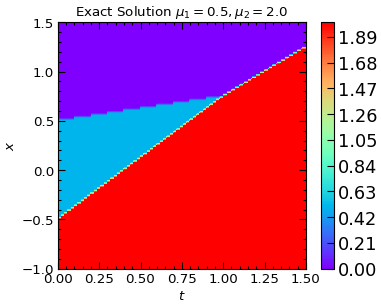

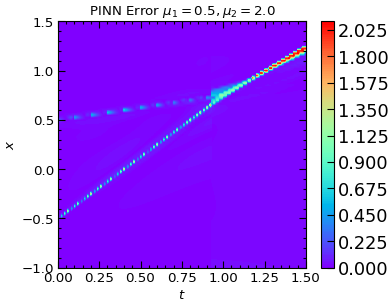

TGPT-PINN at mu_1=0.5,mu_2=2.0 with the rMAE = 0.02134978212416172 and rRMSE = 0.0815240666270256


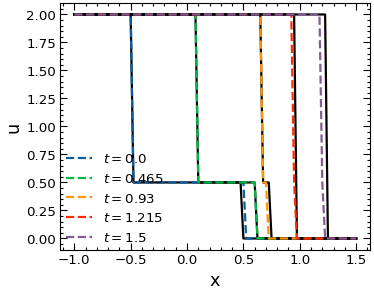

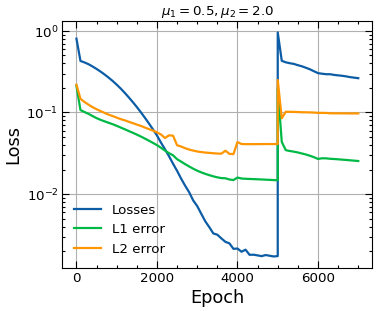

[0.75 1.6 ] stopped at epoch: 0 | gpt_loss: 0.49160921573638916,rMAE: [0.08060312271118164], rRMSE:[0.12202109396457672], 0.011258057318627834, 0.008034818805754185, 0.03996873274445534, 3.1564952223561704e-05
[0.75 1.6 ] stopped at epoch: 2000 | gpt_loss: 0.0048364088870584965,rMAE: 0.021329833194613457, rRMSE:0.027854658663272858, 0.0005531961214728653, 0.00035395738086663187, 2.1323790861060843e-05, 5.304008664097637e-05
[0.75 1.6 ] stopped at epoch: 4000 | gpt_loss: 0.0009235426550731063,rMAE: 0.0029835763853043318, rRMSE:0.018501054495573044, 0.00019332964438945055, 2.3531574697699398e-06, 1.089415832211671e-06, 6.957873119972646e-05
layer1:tensor([[ 1.1767, -0.1228],
        [ 0.0324,  1.1732]], device='cuda:0') and tensor([-0.1277, -0.1845], device='cuda:0') and layer3:tensor([[0.1731, 0.6623]], device='cuda:0')
[0.75 1.6 ] stopped at epoch: 4004 | gpt_loss: 0.00041708711069077253 ,rMAE: 0.0029663187451660633, rRMSE:0.018621139228343964(GPT_PINN Stopping Criteria Met)

第一个峰的最高值索

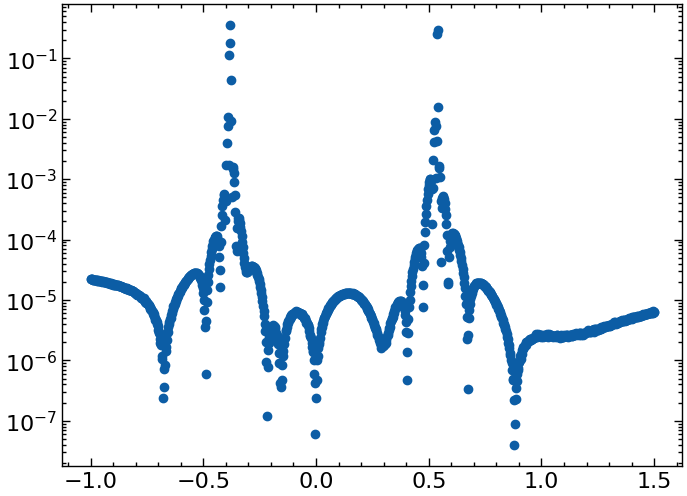

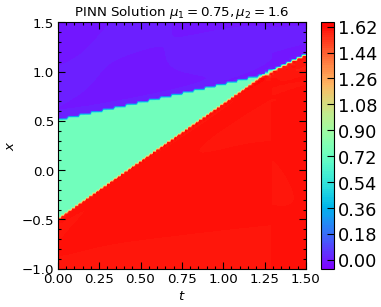

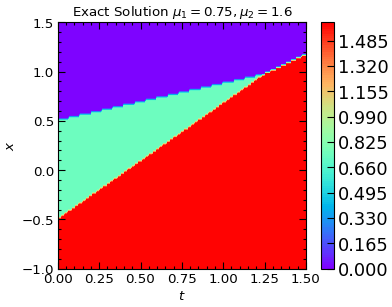

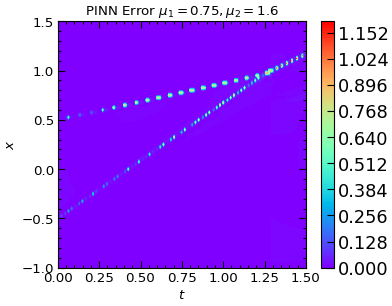

TGPT-PINN at mu_1=0.75,mu_2=1.6 with the rMAE = 0.007346789818257093 and rRMSE = 0.032644595950841904


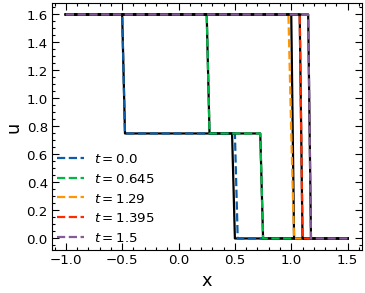

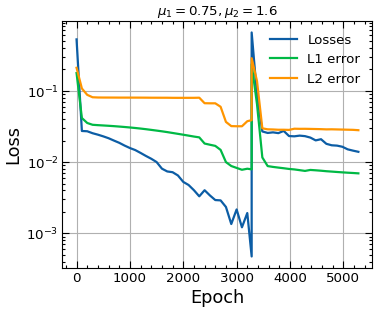

[0.75 1.8 ] stopped at epoch: 0 | gpt_loss: 0.0036729297135025263,rMAE: [0.01320204883813858], rRMSE:[0.0617881640791893], 0.003343020100146532, 1.0231053693132708e-06, 4.029145657113986e-07, 3.1564952223561704e-05
layer1:tensor([[ 0.9971, -0.0689],
        [ 0.0041,  1.1327]], device='cuda:0') and tensor([0.0028, 0.0067], device='cuda:0') and layer3:tensor([[0.5000, 0.4999]], device='cuda:0')
[0.75 1.8 ] stopped at epoch: 1084 | gpt_loss: 0.0004637870588339865 ,rMAE: 0.004162298981100321, rRMSE:0.024001356214284897(GPT_PINN Stopping Criteria Met)

第一个峰的最高值索引: 250
第二个峰的最高值索引: 614
tensor(0.9100, device='cuda:0') 1.1111115217208862 1.1111111111111112
[0.75 1.8 ] stopped at epoch: 0 | gpt_loss: 0.02840103767812252,rMAE: [0.07052716612815857], rRMSE:[0.1536574363708496], 0.02585943229496479, 1.0231053693132708e-06, 1.82857064601194e-07, 0.00025295463274233043
[0.75 1.8 ] stopped at epoch: 2000 | gpt_loss: 0.001053290325216949,rMAE: 0.007763270288705826, rRMSE:0.04488665983080864, 0.0004049

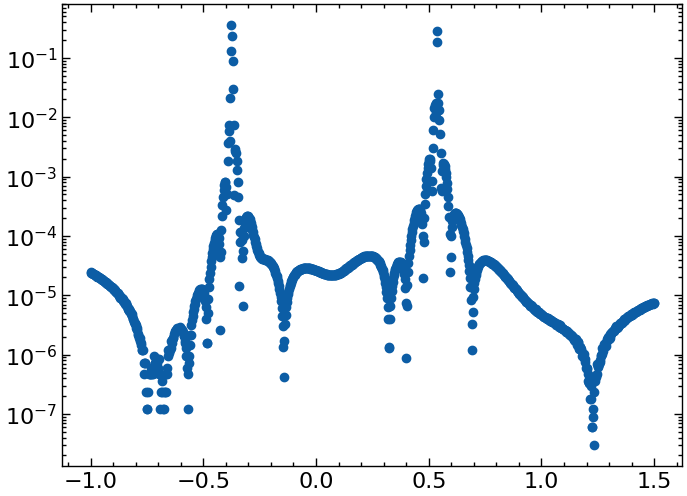

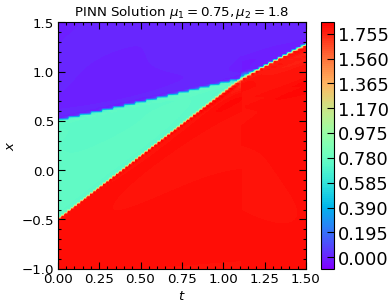

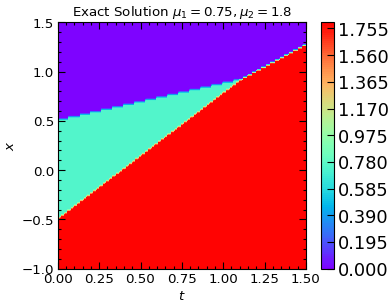

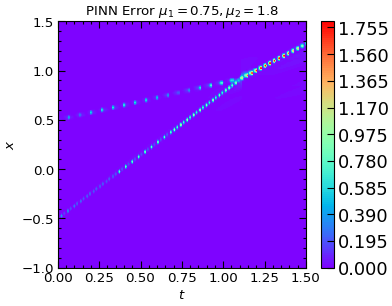

TGPT-PINN at mu_1=0.75,mu_2=1.8 with the rMAE = 0.006748990621417761 and rRMSE = 0.04546843469142914


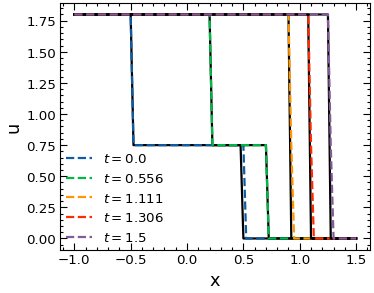

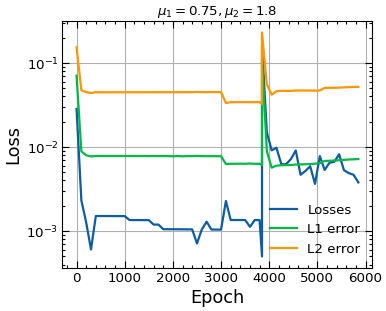

[0.75 2.  ] stopped at epoch: 0 | gpt_loss: 0.4936198890209198,rMAE: [0.07395961135625839], rRMSE:[0.11347412317991257], 0.013311338610947132, 0.007967224344611168, 0.04003206640481949, 3.1564952223561704e-05
[0.75 2.  ] stopped at epoch: 2000 | gpt_loss: 0.0054399012587964535,rMAE: 0.01964566670358181, rRMSE:0.03148631006479263, 0.0008861897513270378, 0.00034700019750744104, 1.8419281332171522e-05, 8.99516380741261e-05
[0.75 2.  ] stopped at epoch: 4000 | gpt_loss: 0.0009795522782951593,rMAE: 0.0067701181396842, rRMSE:0.025824138894677162, 0.0005734756123274565, 1.0861090231628623e-05, 2.0947443601926352e-07, 2.9537097361753695e-05
[0.75 2.  ] stopped at epoch: 5000 | gpt_loss: 0.0012482193997129798,rMAE: 0.006279329769313335, rRMSE:0.02545793168246746, 0.000567412527743727, 6.703368853777647e-06, 5.311697464094323e-07, 6.084614869905636e-05
layer1:tensor([[ 0.9066, -0.0137],
        [-0.0680,  1.2642]], device='cuda:0') and tensor([0.0523, 0.0601], device='cuda:0') and layer3:tensor(

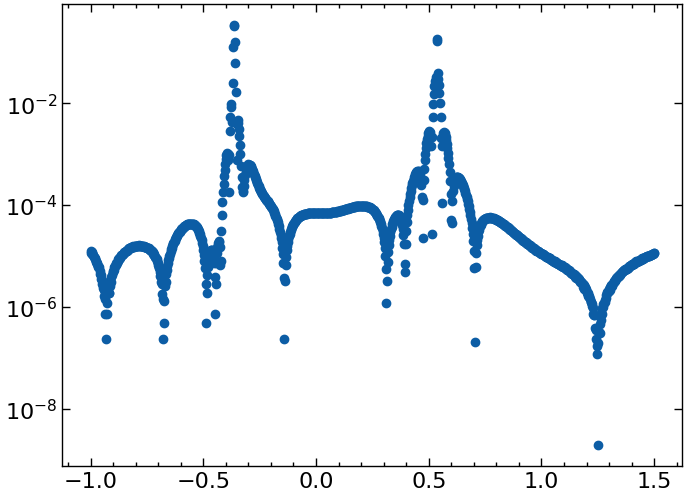

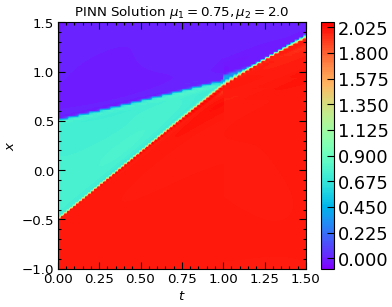

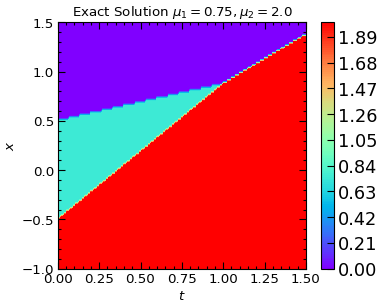

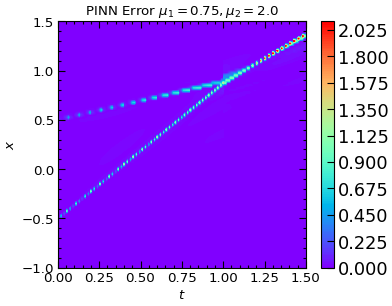

TGPT-PINN at mu_1=0.75,mu_2=2.0 with the rMAE = 0.010518894530832767 and rRMSE = 0.05815611034631729


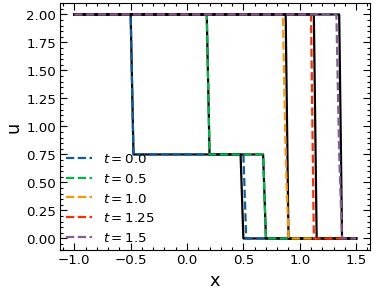

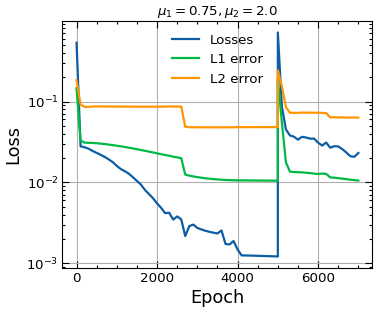

[1.  1.6] stopped at epoch: 0 | gpt_loss: 0.7645946741104126,rMAE: [0.19252446293830872], rRMSE:[0.1889427751302719], 0.03467882424592972, 0.03299129009246826, 0.03996872901916504, 3.1564952223561704e-05
[1.  1.6] stopped at epoch: 2000 | gpt_loss: 0.11293592303991318,rMAE: 0.07742004096508026, rRMSE:0.09615528583526611, 0.008430128917098045, 0.009903720580041409, 0.0005060805124230683, 4.077803168911487e-05
[1.  1.6] stopped at epoch: 4000 | gpt_loss: 0.1067487820982933,rMAE: 0.06342105567455292, rRMSE:0.07797712832689285, 0.005840112920850515, 0.00959689449518919, 0.0004163410631008446, 7.763059693388641e-05
[1.  1.6] stopped at epoch: 5000 | gpt_loss: 0.10525605082511902,rMAE: 0.06247076392173767, rRMSE:0.07711780071258545, 0.005713877733796835, 0.009478865191340446, 0.0003958286251872778, 7.95230153016746e-05
layer1:tensor([[ 1.7684, -2.9875],
        [ 0.2242,  4.3452]], device='cuda:0') and tensor([-0.5213,  0.1168], device='cuda:0') and layer3:tensor([[0.1611, 0.6893]], device='

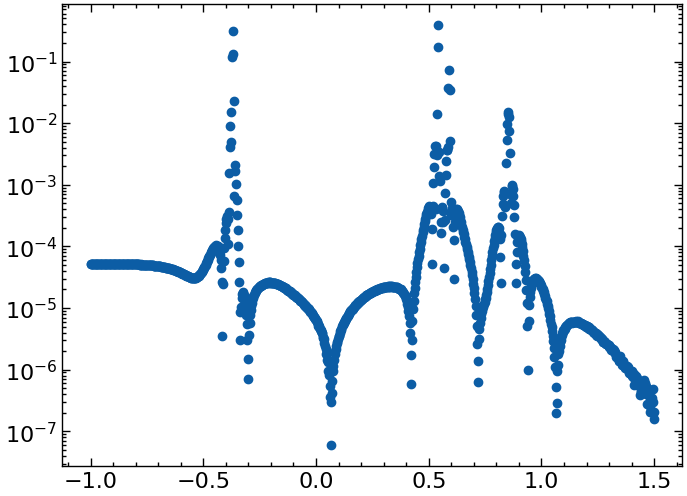

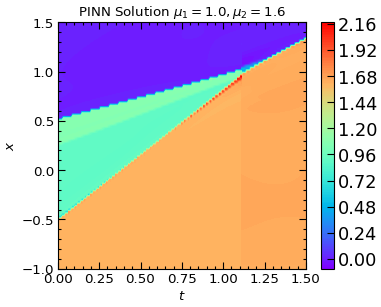

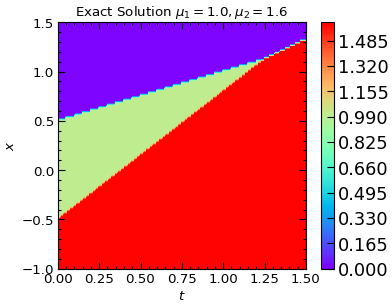

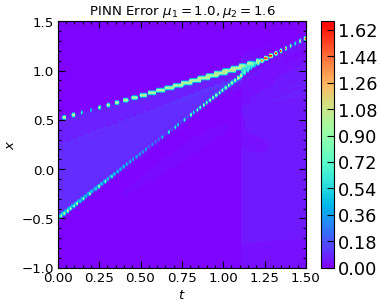

TGPT-PINN at mu_1=1.0,mu_2=1.6 with the rMAE = 0.03571503609418869 and rRMSE = 0.07869981974363327


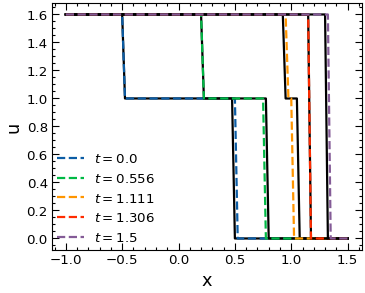

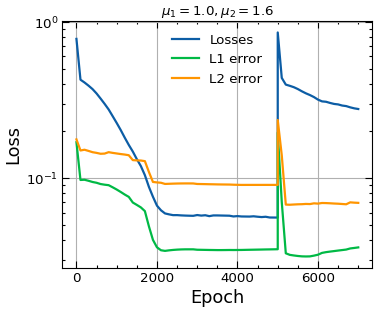

[1.  1.8] stopped at epoch: 0 | gpt_loss: 0.27665838599205017,rMAE: [0.12801086902618408], rRMSE:[0.15513576567173004], 0.026763783767819405, 0.02495749481022358, 4.029145657113986e-07, 3.1564952223561704e-05
layer1:tensor([[ 1.0074, -0.2062],
        [-0.0053,  1.1531]], device='cuda:0') and tensor([-0.0013, -0.0023], device='cuda:0') and layer3:tensor([[-0.3232,  1.1584]], device='cuda:0')
[1.  1.8] stopped at epoch: 1966 | gpt_loss: 0.0003772148338612169 ,rMAE: 0.0031838484574109316, rRMSE:0.01886717975139618(GPT_PINN Stopping Criteria Met)

第一个峰的最高值索引: 256
第二个峰的最高值索引: 618
tensor(0.9050, device='cuda:0') 1.0526319742202759 1.1111111111111112
[1.  1.8] stopped at epoch: 0 | gpt_loss: 0.284819096326828,rMAE: [0.09471108764410019], rRMSE:[0.15654979646205902], 0.034751664847135544, 0.02495749481022358, 1.9014778729342652e-07, 4.905668902210891e-05
layer1:tensor([[ 1.0010, -0.2002],
        [ 0.0021,  1.1316]], device='cuda:0') and tensor([0.0013, 0.0050], device='cuda:0') and layer3:te

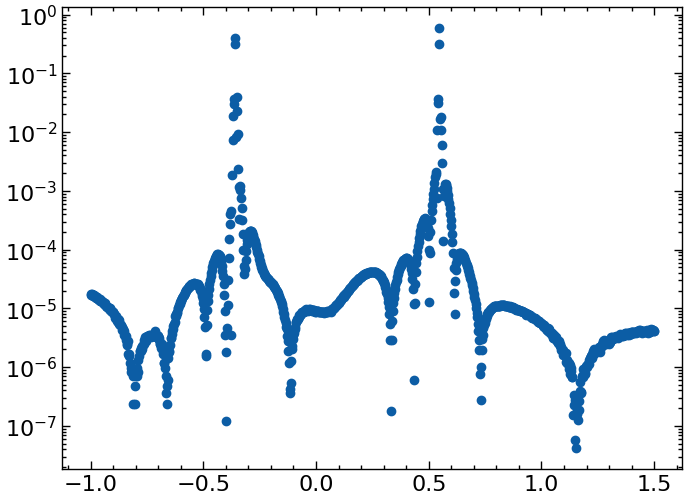

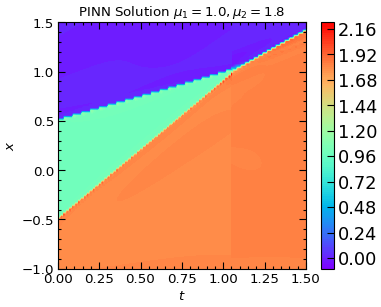

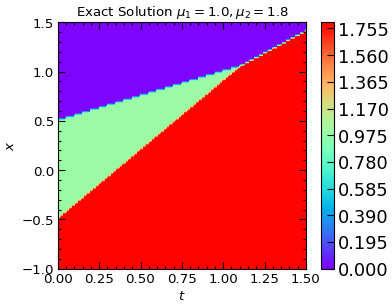

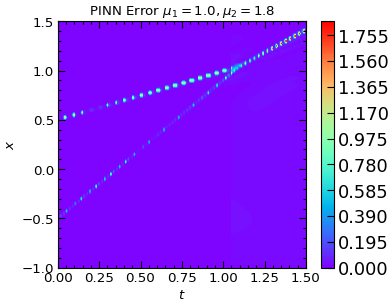

TGPT-PINN at mu_1=1.0,mu_2=1.8 with the rMAE = 0.012645069509744644 and rRMSE = 0.043300922960042953


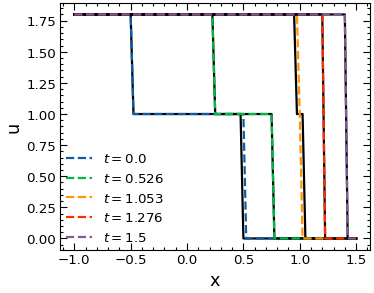

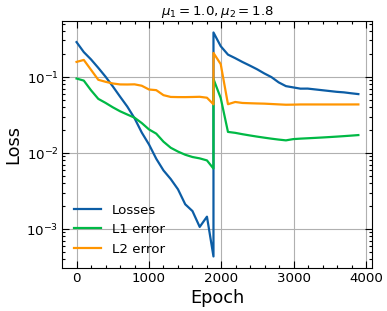

[1. 2.] stopped at epoch: 0 | gpt_loss: 0.7666053771972656,rMAE: [0.1763749122619629], rRMSE:[0.17301876842975616], 0.03673210367560387, 0.03292369842529297, 0.04003206640481949, 3.1564952223561704e-05
[1. 2.] stopped at epoch: 2000 | gpt_loss: 0.02548816241323948,rMAE: 0.039345789700746536, rRMSE:0.05364444479346275, 0.0024117787834256887, 0.0021661678329110146, 0.00011414018808864057, 2.7330428565619513e-05
[1. 2.] stopped at epoch: 4000 | gpt_loss: 0.0011704107746481895,rMAE: 0.0041412729769945145, rRMSE:0.015856333076953888, 0.000243805639911443, 1.7088857930502854e-05, 7.732985523034586e-07, 7.479835767298937e-05
[1. 2.] stopped at epoch: 5000 | gpt_loss: 0.0008202880271710455,rMAE: 0.0016644027782604098, rRMSE:0.015591336414217949, 0.00023018423235043883, 2.1781215764349326e-06, 4.590035462825881e-09, 5.6827670050552115e-05
layer1:tensor([[ 1.0431, -0.2553],
        [-0.0564,  1.1892]], device='cuda:0') and tensor([-0.0561, -0.1082], device='cuda:0') and layer3:tensor([[4.0445e-0

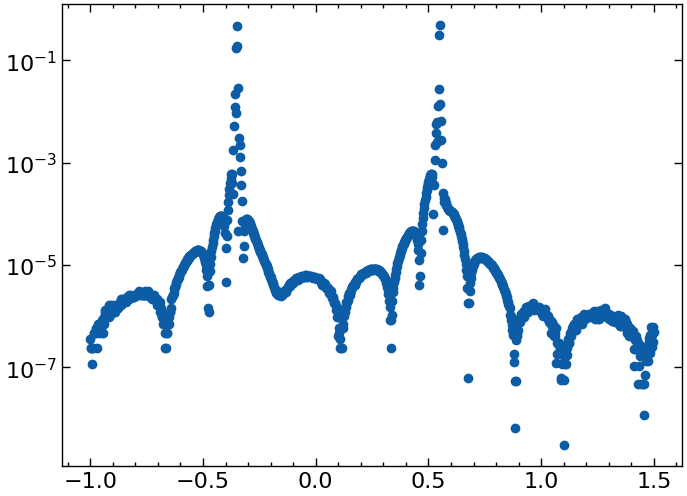

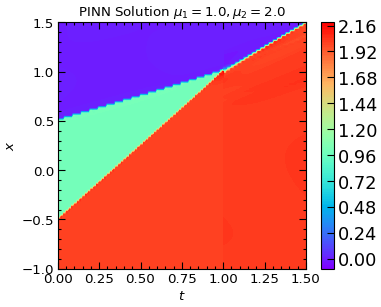

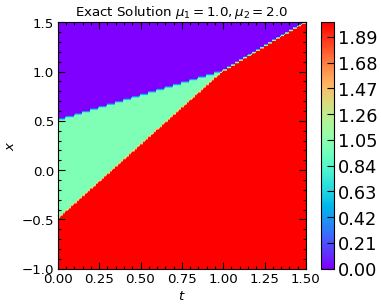

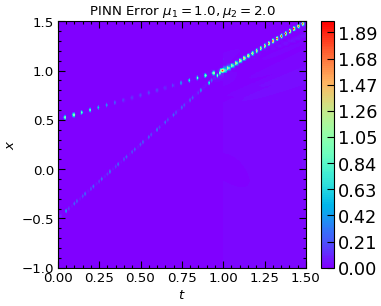

TGPT-PINN at mu_1=1.0,mu_2=2.0 with the rMAE = 0.008991911076009274 and rRMSE = 0.03682442009449005


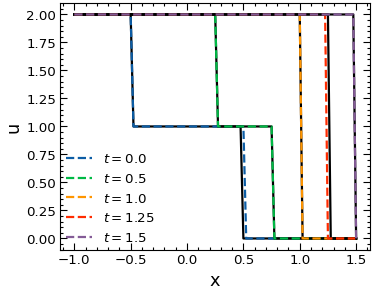

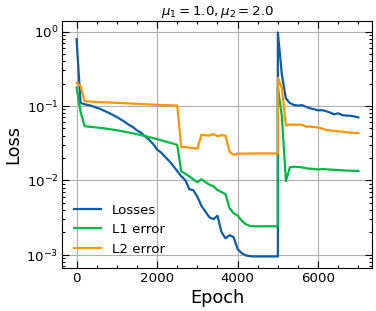

In [13]:
nu_loss1 = []
nu_loss2 = []
L1_err1 = []
L2_err1 = []
L1_err2 = []
L2_err2 = []
L1_err = []
L2_err= []
gpt_train_time_1 = time.perf_counter()
for nu in nu_training:
    if (nu[0] <= nu[1]) and (nu[0] <= (2*nu[1]-3/4*nu[1]**2)):
        #T_cut = 2/nu[1]
        residual_data0 = create_residual_data(Xi, Xf, Ti, Tf0, Nx_train0, Nt_train0, Nx_test, Nt_test, dx,dt)
        xt_resid0      = residual_data0[0].to(device)
        f_hat0         = residual_data0[1].to(device)
        xt_test0       = residual_data0[2].to(device)
        xt_RHL0      = residual_data0[3].to(device)
        xt_RHR0      = residual_data0[4].to(device)
        xt_RHt0         = residual_data0[5].to(device)
        xt_RHtL0       = residual_data0[6].to(device)

        BC_data = create_BC_data(Xi, Xf, Ti, Tf0, BC_pts)
        BC1     = BC_data[0].to(device)
        BC2     = BC_data[1].to(device)

        IC_data0 = create_IC_data(nu,Xi, Xf, Ti, Tf0, IC_pts, IC_simple)
        IC_xt0     = IC_data0[0].to(device)
        IC_u0      = IC_data0[1].to(device)
        #plt.scatter(IC_xt[:,1].detach().cpu(),IC_xt[:,0].detach().cpu(),s=0.1)
        xt_en = Move_Time_1D(IC_xt0, Tf0).to(device)

        Exact_y0 = exact_u(nu,xt_test0)[:,None].to(device)

        GPT_PINN0 = GPT1(nu, layers_gpt, P1_list[0:i+1], c_initial,xt_resid0, f_hat0, Exact_y0, xt_test0, IC_xt0, IC_u0,  BC1, BC2,xt_RHL0,xt_RHR0,xt_RHt0,xt_RHtL0,Nx_train0,Nt_train0,dt).to(device)

        gpt1_losses = gpt1_train(GPT_PINN0, nu, xt_resid0, f_hat0, Exact_y0, xt_test0, IC_xt0, IC_u0, BC1, BC2, epochs_gpt1, lr_gpt1, tol_gpt)        

        ################################################
        xt_test_cut = create_residual_data(Xi, Xf, Ti, Tf0, Nx_train0, Nt_train0, Nx_test0, Nt_test0, dx,dt)[2].to(device)
        cut_x = torch.cat([xt_test_cut[:Nx_test0, 0].unsqueeze(1), Tf0 * torch.ones(Nx_test0, 1).to(device)], dim=1)
        cut_dx1 = torch.cat([xt_test_cut[:Nx_test0, 0].unsqueeze(1)+dx, Tf0 * torch.ones(Nx_test0, 1).to(device)], dim=1)
        cut_dx2 = torch.cat([xt_test_cut[:Nx_test0, 0].unsqueeze(1)-dx, Tf0 * torch.ones(Nx_test0, 1).to(device)], dim=1)
        diff_x=torch.abs(GPT_PINN0(cut_dx2)-GPT_PINN0(cut_dx1))
        plt.scatter(cut_x[:Nx_test0,0].detach().cpu(),diff_x.detach().cpu())
        plt.yscale('log')

        y=diff_x.squeeze()
        # Step 1: 找到所有局部极大值的索引
        grad = torch.diff(y)  # 一阶差分来获取梯度
        local_maxima = (grad[:-1] > 0) & (grad[1:] < 0)  # 局部极大值条件
        peak_indices = torch.nonzero(local_maxima)[:, 0] + 1  # 局部极大值索引加 1 来对齐原数组

        # Step 2: 找到两个峰值区域，挑选每个峰值区域的最高点
        # 将极大值分为两组，按索引划分，假设两峰在不同区域
        # （如果位置未知，也可以使用聚类算法对这些峰值进行分组）

        # 例如假设前半段和后半段各有一个峰
        first_peak_region = peak_indices[peak_indices < len(y) // 2]
        second_peak_region = peak_indices[peak_indices >= len(y) // 2]

        # Step 3: 获取每个区域的最大值索引
        first_peak_index = first_peak_region[y[first_peak_region].argmax()]
        second_peak_index = second_peak_region[y[second_peak_region].argmax()]

        print("第一个峰的最高值索引:", first_peak_index.item())
        print("第二个峰的最高值索引:", second_peak_index.item())

        cut_dx=torch.abs(cut_x[second_peak_index,0]-cut_x[first_peak_index,0])
        T_cut = (Tf0/(1-cut_dx)).item()
        print(cut_dx,T_cut,2/nu[1])
        ################################################


        residual_data1 = create_residual_data(Xi, Xf, Ti, T_cut, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
        xt_resid1      = residual_data1[0].to(device)
        f_hat1         = residual_data1[1].to(device)
        xt_test1       = residual_data1[2].to(device)
        xt_RHL1      = residual_data1[3].to(device)
        xt_RHR1      = residual_data1[4].to(device)
        xt_RHt1         = residual_data1[5].to(device)
        xt_RHtL1       = residual_data1[6].to(device)
        ind = torch.logical_and(xt_resid1[:,0]>-1,xt_resid1[:,0]<1)

        BC_data1 = create_BC_data(Xi, Xf, Ti, T_cut, BC_pts)
        BC1     = BC_data1[0].to(device)
        BC2      = BC_data1[1].to(device)
        
        IC_data3 = create_IC_data(nu, Xi, Xf, Ti, T_cut, IC_pts, IC_simple)
        IC_xt3     = IC_data3[0].to(device)
        IC_u3      = IC_data3[1].to(device)

        Exact_y3 = exact_u(nu,xt_test1)[:,None].to(device)
        #f_hat = exact_u(nu,xt_resid1)[:,None].clone().to(device)        
        GPT_PINN1 = GPT1(nu, layers_gpt, P1_list[0:i+1], c_initial,xt_resid1, f_hat1, Exact_y3, xt_test1, IC_xt3, IC_u3,  BC1, BC2,xt_RHL1,xt_RHR1,xt_RHt1,xt_RHtL1,Nx_train,Nt_train,dt).to(device)

        gpt1_losses = gpt1_train(GPT_PINN1, nu, xt_resid1, f_hat1, Exact_y3, xt_test1, IC_xt3, IC_u3, BC1, BC2, epochs_gpt1, lr_gpt1, tol_gpt)

        
        nu_loss1.append(gpt1_losses[0].item())
        L1_err1.append(gpt1_losses[3][-1])
        L2_err1.append(gpt1_losses[4][-1])
        '''
        ###   Plot1   ###
        plt.figure(dpi=80, figsize=(5,4))
        plt.plot(xt_test1[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),Exact_y3[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),label='Exact solution')
        plt.plot(xt_test1[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),GPT_PINN1.forward(xt_test1)[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),label = 'TGPT-IFNN1 solution')

        plt.xlabel("x",     fontsize=16)
        plt.ylabel("u",     fontsize=16)

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=12)

        plt.legend(fontsize = 12)#20
        plt.show()

        #Burgers_plot(xt_test1, Exact_y3, Nx_test,Nt_test, title=fr"Step1 Exact Solution $\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$")
        #Burgers_plot(xt_test1, GPT_PINN1.forward(xt_test1),Nx_test,Nt_test, title=fr"TGPT-IFNN1 Solution $\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$")
        #Burgers_plot(xt_test1, abs(GPT_PINN1.forward(xt_test1)-Exact_y3), Nx_test,Nt_test,title=fr"TGPT-IFNN1 Error $\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$")

        plt.figure(dpi=80, figsize=(5,4))    
        plt.plot(gpt1_losses[1], gpt1_losses[2], label="Loss")
        plt.plot(gpt1_losses[1], gpt1_losses[3], label="L1 error")
        plt.plot(gpt1_losses[1], gpt1_losses[4], label="L2 error")

        plt.xlabel("Epoch",     fontsize=16)
        plt.ylabel("Loss and Error", fontsize=16)

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=12)

        plt.grid(True)
        plt.xlim(0,max(gpt1_losses[1]))
        plt.yscale('log')
        plt.title(fr"TGPT-IFNN1 Loss and error $\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$", fontsize=12)
        plt.legend(fontsize = 12)#
        plt.show()
        '''
        ##########################################
        rMAE = max(sum(abs(GPT_PINN1.forward(xt_test1)-Exact_y3))/sum(abs(Exact_y3)))
        rRMSE = torch.sqrt(sum((GPT_PINN1.forward(xt_test1)-Exact_y3)**2)/sum((Exact_y3)**2))
        print(f"TGPT1-PINN at {nu} with the rMAE = {rMAE} and rRMSE = {rRMSE.item()}")
        ############################################################################################################
        residual_data2 = create_residual_data(Xi, Xf, T_cut, Tf, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
        xt_resid2      = residual_data2[0].to(device)
        f_hat2         = residual_data2[1].to(device)
        xt_test2       = residual_data2[2].to(device)
        xt_RHL2      = residual_data2[3].to(device)
        xt_RHR2      = residual_data2[4].to(device)
        xt_RHt2         = residual_data2[5].to(device)
        xt_RHtL2       = residual_data2[6].to(device)
        ind = torch.logical_and(xt_resid2[:,0]>-1,xt_resid2[:,0]<1)

        BC_data2 = create_BC_data(Xi, Xf, T_cut,Tf, BC_pts)
        BC1     = BC_data2[0].to(device)
        BC2       = BC_data2[1].to(device)

        IC_data4 = create_IC_data(nu, Xi, Xf, T_cut, Tf, IC_pts, IC_simple)
        IC_xt4     = IC_data4[0].to(device)
        IC_u4     = IC_data4[1].to(device)
        Exact_y4 = exact_u(nu,xt_test2)[:,None].to(device)
        #f_hat = exact_u(nu,xt_resid2)[:,None].clone().to(device)
        GPT_PINN2 = GPT2(nu, layers_gpt, P2_list[0:i+1], c_initial,xt_resid2, f_hat2, Exact_y4, xt_test2, IC_xt4, IC_u4,  BC1, BC2,xt_RHL2,xt_RHR2,xt_RHt2,xt_RHtL2,Nx_train,Nt_train,dt,T_cut).to(device)
        gpt2_losses = gpt2_train(GPT_PINN2, nu, GPT_PINN1, xt_resid2, f_hat2, Exact_y4, xt_test2, IC_xt4, IC_u4, BC1, BC2, epochs_gpt2, lr_gpt2, tol_gpt)
        nu_loss2.append(gpt2_losses[0].item())
        L1_err2.append(gpt2_losses[3][-1])
        L2_err2.append(gpt2_losses[4][-1])
        ###########################################################
        #Burgers_plot(xt_test2, Exact_y4, Nx_test,Nt_test, title=fr"Step2 Exact Solution $\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$")
        #Burgers_plot(xt_test2, GPT_PINN2.forward(xt_test2),Nx_test,Nt_test, title=fr"TGPT-IFNN2 Solution $\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$")
        #Burgers_plot(xt_test2, abs(GPT_PINN2.forward(xt_test2)-Exact_y4), Nx_test,Nt_test,title=fr"TGPT-IFNN2 Error  $\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$")
        '''
        plt.figure(dpi=80, figsize=(5,4))    
        plt.plot(gpt2_losses[1], gpt2_losses[2],linewidth=2, label="Loss")
        plt.plot(gpt2_losses[1], gpt2_losses[3],linewidth=2, label="L1 error")
        plt.plot(gpt2_losses[1], gpt2_losses[4],linewidth=2, label="L2 error")

        plt.xlabel("Epoch",     fontsize=16)
        plt.ylabel("Loss and Error", fontsize=16)

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=12)

        plt.grid(True)
        plt.xlim(0,max(gpt2_losses[1]))
        plt.yscale('log')
        plt.title(fr"TGPT-IFNN2 Loss and error $\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$", fontsize=12)
        plt.legend(fontsize = 12)
        plt.show()
        '''
        rMAE = max(sum(abs(GPT_PINN2.forward(xt_test2)-Exact_y4))/sum(abs(Exact_y4)))
        rRMSE = torch.sqrt(sum((GPT_PINN2.forward(xt_test2)-Exact_y4)**2)/sum((Exact_y4)**2))
        print(f"TGPT2-PINN at {nu} with the rMAE = {rMAE} and rRMSE = {rRMSE.item()}")

        Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((GPT_PINN1(xt_test1),GPT_PINN2(xt_test2)),0),Nx_test,2*Nt_test, title=fr"TGPT-PINN Solution $\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$")
        Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((Exact_y3,Exact_y4),0),Nx_test,2*Nt_test, title=fr"Exact Solution $\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$")
        Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((abs(GPT_PINN1(xt_test1)-Exact_y3),abs(GPT_PINN2(xt_test2)-Exact_y4)),0),Nx_test,2*Nt_test, title=fr"TGPT-PINN Error $\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$")
        rMAE = max(sum(abs(torch.cat((GPT_PINN1(xt_test1),GPT_PINN2(xt_test2)),0)-torch.cat((Exact_y3,Exact_y4),0)))/sum(abs(torch.cat((Exact_y3,Exact_y4),0)))).item()
        rRMSE = torch.sqrt(sum((torch.cat((GPT_PINN1(xt_test1),GPT_PINN2(xt_test2)),0)-torch.cat((Exact_y3,Exact_y4),0))**2)/sum((torch.cat((Exact_y3,Exact_y4),0))**2)).item()
        print(f"TGPT-PINN at mu_1={round(nu[0],3)},mu_2={round(nu[1],3)} with the rMAE = {rMAE} and rRMSE = {rRMSE}")
        L1_err.append(rMAE)
        L2_err.append(rRMSE)
        
        plt.figure(dpi=80, figsize=(5,4))#dpi=150, figsize=(10,8)
        gap = 100
        for ind in range(1, Nt_test+1,gap):
            xx = torch.cat((xt_test1,xt_test2),0)[0:Nx_test,:1]
            t = (ind-1)*(T_cut-Ti)/(Nt_test-1)
            Exact = torch.cat((Exact_y3,Exact_y4),0)[(ind-1)*Nx_test:ind*Nx_test,0]
            TGPT = torch.cat((GPT_PINN1(xt_test1),GPT_PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,:1]
            plt.plot(xx.detach().cpu(),Exact.detach().cpu(),'k')
            #plt.scatter(xt_test[0:Nx_test,0].detach().cpu(),PINN(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),s=20,label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
            plt.plot(xx.detach().cpu(),initial_u(nu,xx-TGPT*t).detach().cpu(),'--',label=fr"$t={round((ind-1)*(T_cut-Ti)/(Nt_test-1),3)}$")
        for ind in range(Nt_test+1+gap, 2*Nt_test+1,gap):
            xx = torch.cat((xt_test1,xt_test2),0)[0:Nx_test,:1]
            t = T_cut+(ind-Nt_test-1)*(Tf-T_cut)/(Nt_test-1)
            Exact = torch.cat((Exact_y3,Exact_y4),0)[(ind-1)*Nx_test:ind*Nx_test,0]
            TGPT = torch.cat((GPT_PINN1(xt_test1),GPT_PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,:1]
            plt.plot(xx.detach().cpu(),Exact.detach().cpu(),'k')
            #plt.scatter(xt_test[0:Nx_test,0].detach().cpu(),PINN(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),s=20,label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
            plt.plot(xx.detach().cpu(),initial_u(nu,xx-TGPT*t).detach().cpu(),'--',label=fr"$t={round(t,3)}$")

        plt.xlabel("x",     fontsize=16)
        plt.ylabel("u", fontsize=16)

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=12)

        plt.legend(loc=(0,0),fontsize = 12)#
        plt.show()

        pinn1_losses = torch.tensor(gpt1_losses[1:])
        pinn2_losses = torch.tensor(gpt2_losses[1:])
        plt.figure(dpi=80, figsize=(5,4))    
        plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[1],pinn2_losses[1]),0), label="Losses")
        plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[2],pinn2_losses[2]),0), label="L1 error")
        plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[3],pinn2_losses[3]),0), label="L2 error")
        #plt.plot(pinn1_losses[0], pinn1_losses[4], label="Loss_pde")

        plt.xlabel("Epoch",     fontsize=16)
        plt.ylabel("Loss", fontsize=16)

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=12)

        plt.grid(True)
        #plt.xlim(0,max(pinn1_losses[0]))
        plt.yscale('log')
        plt.title(fr"$\mu_1={round(nu[0],3)},\mu_2={round(nu[1],3)}$", fontsize=12)
        plt.legend(fontsize = 12)#
        plt.show()
        
    else:
        nu_loss1.append(0.0)
        L1_err1.append(0.0)
        L2_err1.append(0.0)
        nu_loss2.append(0.0)
        L1_err2.append(0.0)
        L2_err2.append(0.0)
